In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
warnings.filterwarnings("ignore")

In [2]:
# Load the dataset
df = pd.read_csv("Maternal Health Risk Data Set.csv")
print("Dataset Loaded Successfully!")

Dataset Loaded Successfully!


In [3]:
# Display basic information about the dataset
print("\nDataset Overview:")
print(df.info())
print(df.head())


Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB
None
   Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  RiskLevel
0   25         130           80  15.0      98.0         86  high risk
1   35         140           90  13.0      98.0         70  high risk
2   29          90           70   8.0     100.0         80  high risk
3   30         140           85   7.0      98.0         70  high risk
4   35         120           60   6.1      98.0         76   low risk


In [4]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64


In [9]:
# Encode categorical variables (if any)
if df.select_dtypes(include=['object']).shape[1] > 0:
    label_encoders = {}
    for col in df.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

In [11]:
# Feature scaling
scaler = StandardScaler()
X = df.drop(columns=['RiskLevel'])  # Assuming 'RiskLevel' is the target variable
y = df['RiskLevel']
X_scaled = scaler.fit_transform(X)

In [13]:
# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)
print("\nDataset Balanced Using SMOTE")


Dataset Balanced Using SMOTE


In [15]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)
print("\nDataset Split into Training and Testing Sets")


Dataset Split into Training and Testing Sets


In [17]:
# Define models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "AdaBoost": AdaBoostClassifier(),
    "MLP": MLPClassifier(max_iter=500),
    "XGBoost": XGBClassifier()
}

In [19]:
# Train and evaluate models
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred))


Training Random Forest...
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92        81
           1       0.91      0.77      0.83        81
           2       0.77      0.83      0.80        82

    accuracy                           0.85       244
   macro avg       0.86      0.85      0.85       244
weighted avg       0.86      0.85      0.85       244


Training Logistic Regression...
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.75      0.74        81
           1       0.62      0.60      0.61        81
           2       0.46      0.45      0.45        82

    accuracy                           0.60       244
   macro avg       0.60      0.60      0.60       244
weighted avg       0.60      0.60      0.60       244


Training SVM...
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.88    

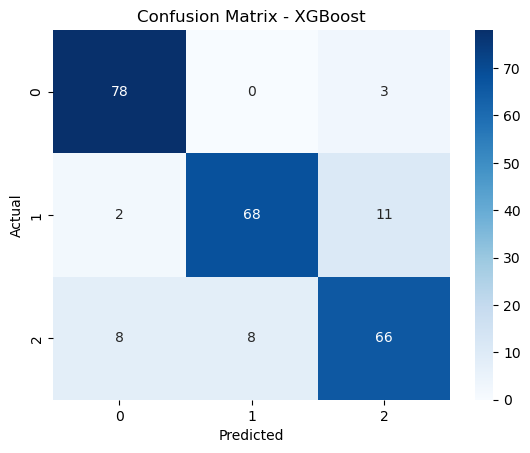

In [21]:
    # Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix - {name}")
plt.show()

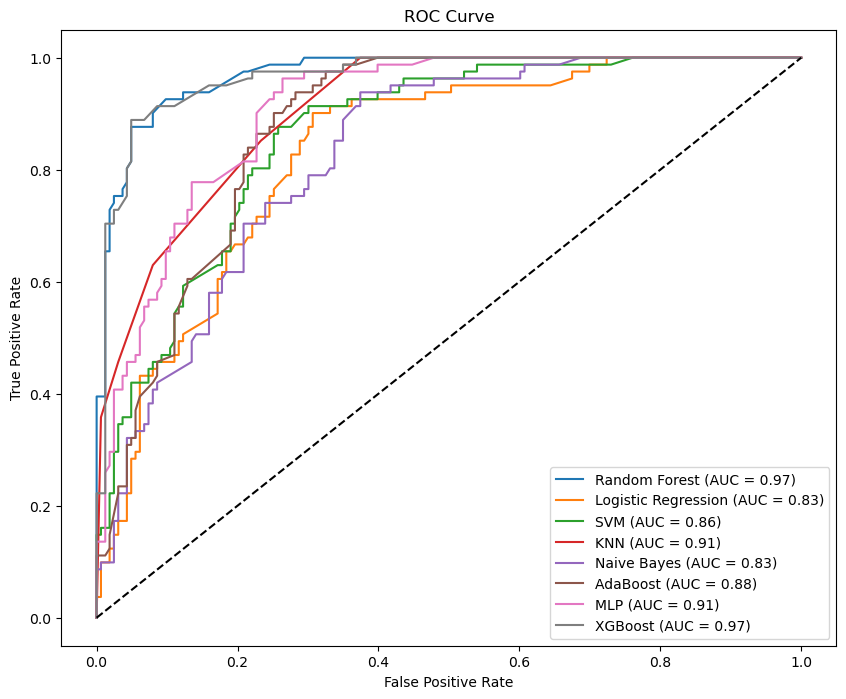

In [23]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_pred_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test == 1, y_pred_prob)  # Adjust for binary/multi-class cases.
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


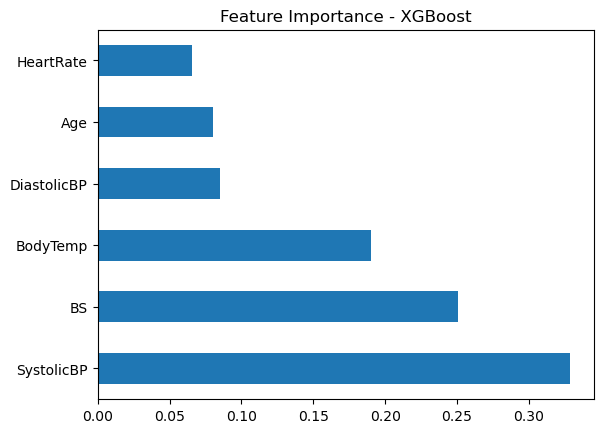

In [25]:
# Feature importance (for tree-based models)
if hasattr(model, "feature_importances_"):
    feature_importances = pd.Series(model.feature_importances_, index=X.columns)
    feature_importances.nlargest(10).plot(kind='barh')
    plt.title(f"Feature Importance - {name}")
    plt.show()